In [1]:
from nlp_tweets.preprocess import clean_text, get_sequences, get_embedding_matrix
from nlp_tweets.model import get_model
from nlp_tweets.eda import plot_roc_curve_mean, get_categorial_confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannhallouard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
PATH_RAW = '../data/raw/'
PATH_PROCESSED = '../data/processed/'

TRAIN_COLUMNS = ['id', 'text', 'target']
TEST_COLUMNS = ['id', 'text']
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 100

# Loading

In [37]:
tweets_df = pd.read_csv(PATH_RAW + 'train.csv')
tweets_df = tweets_df[TRAIN_COLUMNS]
tweets_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
tweets_test_df = pd.read_csv(PATH_RAW + 'test.csv')
tweets_test_df = tweets_test_df[TEST_COLUMNS]

# Preprocessing

In [39]:
tweets_df['text'] = tweets_df['text'].map(lambda x: clean_text(x))

In [40]:
data, tokenizer = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, texts=tweets_df['text'])

In [41]:
test_data, _ = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, 
                          texts=tweets_test_df['text'], tokenizer=tokenizer)

In [ ]:
pretrained_embeddings_path = PATH_RAW + "GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [ ]:
embedding_matrix = get_embedding_matrix(tokenizer=tokenizer, 
                                        word2vec=word2vec, 
                                        max_nb_words=MAX_NB_WORDS, 
                                        enbedding_dim=EMBEDDING_DIM)

# Train test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data, tweets_df['target'], test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val)

print(X_train.shape, X_val.shape, X_test.shape)

# Create Model

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GRU, TimeDistributed, \
    Embedding, BatchNormalization, Flatten
from tensorflow.keras.models import Model
import tensorflow
def get_model(vocabulary_size: int, embeding_dim: int, max_sequence_length: int,
              _rnn_nb: [int], _fc_nb: [int], dropout_rate: float) -> tensorflow.keras.models.Model:
    sequence_1_input = Input(shape=(max_sequence_length,), dtype='int32')

    seq = Embedding(vocabulary_size, embeding_dim, input_length=max_sequence_length, trainable=False)(sequence_1_input)
    for _r in _rnn_nb:
        seq = GRU(_r, activation='tanh', dropout=dropout_rate,
                  recurrent_dropout=dropout_rate, return_sequences=True)(seq)

    for _f in _fc_nb:
        seq = TimeDistributed(Dense(_f))(seq)
        seq = Dropout(dropout_rate)(seq)
        seq = TimeDistributed(Dense(_f))(seq)

    seq = Flatten()(seq)
    seq = Dense(10)(seq)
    seq = Activation('relu')(seq)
    seq = Dropout(dropout_rate)(seq)
    seq = BatchNormalization()(seq)
    seq = Dense(1)(seq)
    out = Activation('sigmoid', name='strong_out')(seq)

    model = Model(inputs=sequence_1_input, outputs=out)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
model = get_model(vocabulary_size=MAX_NB_WORDS, embeding_dim=EMBEDDING_DIM, 
                  max_sequence_length=MAX_SEQUENCE_LENGTH,_rnn_nb=[128, 64], _fc_nb=[32], dropout_rate=0.5) 
model.summary()

# Train

In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
)

## Finding the best threshold

In [25]:
pred_proba_train = model.predict(X_train)
pred_proba_val = model.predict(X_val)

Train Accuracy: 0.8854828114736151 
Train Confusion Matrix:
[[2486  110]
 [ 413 1558]]
Test Accuracy: 0.7583187390542907 
Test Confusion Matrix:
[[1136  200]
 [ 352  596]]


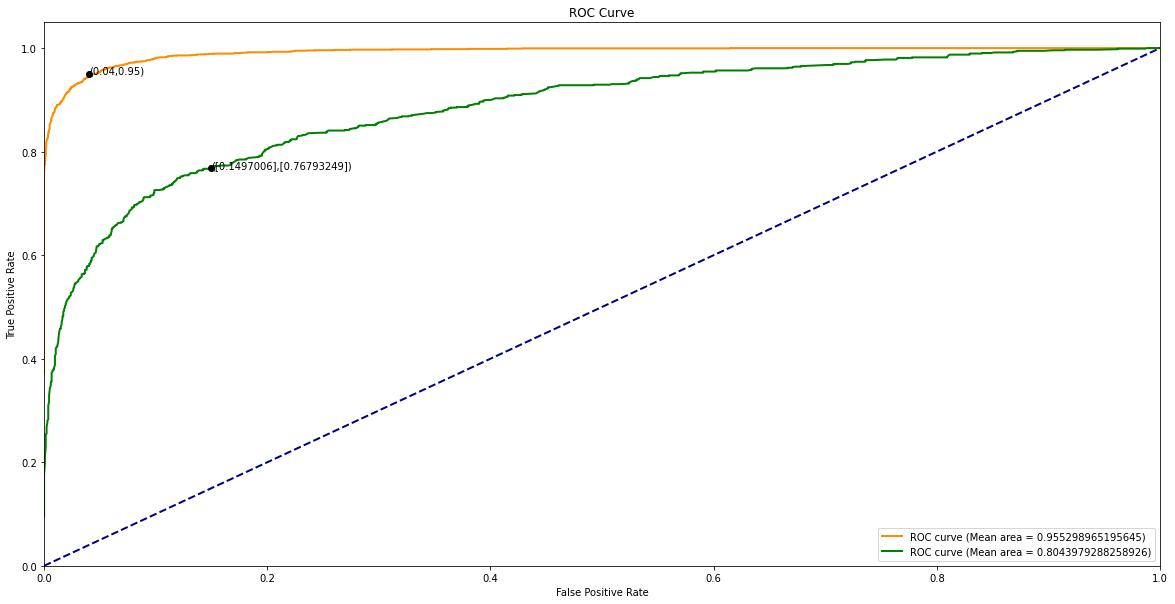

In [26]:
threshold = plot_roc_curve_mean(y_train=y_train.values, y_train_pred_proba=pred_proba_train, 
                        y_test=y_val.values, y_test_pred_proba=pred_proba_val)

## Test

In [27]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 0s 14ms/step - loss: 0.4966 - accuracy: 0.7677


[0.49659639596939087, 0.7677165269851685]

In [28]:
pred_proba_test = model.predict(X_test).reshape(-1)
pred_proba_test = (pred_proba_test > threshold).astype(int)

array([[351.,  59.],
       [117., 235.]])

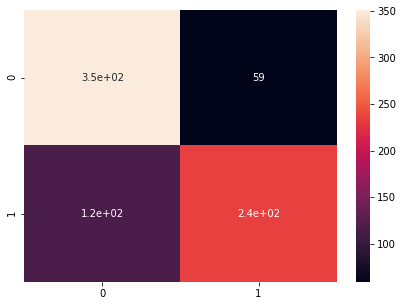

In [29]:
get_categorial_confusion_matrix(y_test, pred_proba_test, display=True)

# Predict

In [30]:
predictions = model.predict(test_data)
predictions = (predictions > threshold).astype(int)

In [33]:
output = pd.read_csv(PATH_RAW + 'sample_submission.csv')
output['target'] = predictions
output.to_csv(PATH_PROCESSED + 'to_submit.csv', index=False)